# An Endpoint using BERT large model (uncased) with the MS_MARCO dataset

---

## Background
Bidirectional Encoder Representations from Transformers (BERT) is a pre-trained language model that 
has achieved state-of-the-art results on numerous natural language processing (NLP) tasks. BERT is a 
transformer-based model, which was fine-tuned for various NLP tasks, including question answering. 
The Stanford Question Answering Dataset (SQuAD) is one such task where BERT has achieved 
significant accuracy compared with other models. However, current research also indicates that 
tuning BERT with new datasets can lead to further improvements in its performances for specific 
tasks. In this proposal, we suggest fine-tuning a pre-trained BERT large model (uncased) with the 
ms_marco dataset using whole word masking and incorporating a fine-tuning approach to improve its 
performances. 

The BERT model is based on the concept of pre-training, as well as fine-tuning, a NLP task. The pre-training process is based on unsupervised objectives, such as the masked language model and the 
next sentence prediction task, to learn contextual representations of words. The fine-tuning process, 
on the other hand, uses supervised training, where the learned pre-trained knowledge is combined 
with task-specific datasets to achieve beƩer performances.

MS_MARCO is a dataset consisting of a large collection of real-world queries and corresponding 
passages that aims to facilitate research in question-answer matching and ranking. It contains more 
than 1 million queries and over 8 million passages, making it one of the largest publicly available 
datasets of its kind. Each query in the dataset was generated by real users of the Bing search engine 
and is paired with relevant passages retrieved from web pages. The dataset is designed to enable 
researchers to develop and evaluate machine learning models for natural language processing tasks 
such as question answering, information retrieval, and passage ranking. The dataset also includes 
information about the relevance of passages to queries, allowing for the evaluation of ranking 
algorithms. Overall, the MS MARCO v1.2 dataset is a valuable resource for anyone interested in 
developing and evaluating algorithms for natural language understanding tasks.


---

## Preparation

Our proposal is to use the BERT large model (uncased) with the MS_MARCO dataset using whole 
word masking as an endpoint to answer question. For this we will go through the following steps: 
* Preparing the data: We will use the MS_MARCO dataset to fine-tune the BERT large model. We will construct a train and test set from the available dataset for fine-tuning. 
* Fine-tuning the model: We will fine-tune the pre-trained BERT model with the MS_MARCO dataset using whole word masking. We will use the Adam optimizer for training and evaluate model performance based on F1 score. 
* Evaluating the model: We will evaluate the fine-tuned model's performance based on MS_Marco's benchmarking metrics. The key evaluation measures will be the F1-score and the exact match (EM) score. 
* Deploy the model. 
* Scale the model so that we can make this application available to a lot more users. 

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [3]:
#!pip install -qU --upgrade pip
!pip install -qU --upgrade boto3

In [4]:
# cell 01
import sagemaker
bucket=sagemaker.Session().default_bucket()
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Now let's bring in the Python libraries that we'll use throughout the analysis

In [5]:
# cell 02
!pip install -qU datasets
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker 
import zipfile     # Amazon SageMaker's Python SDK provides many helper functions
from datasets import load_dataset

---

## Data Importation

Let's start by importing the dataset from Huggingface

In [6]:
validation_data, train_data, test_data = load_dataset('ms_marco', 'v1.1', split =['validation','train', 'test'], cache_dir='/media/data_files/github/website_tutorials/data')

Found cached dataset ms_marco (/media/data_files/github/website_tutorials/data/ms_marco/v1.1/1.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84)


  0%|          | 0/3 [00:00<?, ?it/s]

Now lets read this into a Pandas data frame and take a look.

In [7]:
data = pd.concat([pd.DataFrame(validation_data), pd.DataFrame(train_data), pd.DataFrame(test_data)],ignore_index=True)
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)
data.head(3)

,answers,passages,query,query_id,query_type,wellFormedAnswers
0,"[Approximately $15,000 per year.]","{'is_selected': [1, 0, 0, 0, 0, 0], 'passage_t...",walgreens store sales average,9652,numeric,[]
1,"[$21,550 per year, The average hourly wage for...","{'is_selected': [0, 1, 0, 0, 0, 0, 0, 0], 'pas...",how much do bartenders make,9653,numeric,[]
2,"[A boil, also called a furuncle, is a deep fol...","{'is_selected': [0, 0, 0, 0, 0, 0, 1, 0], 'pas...",what is a furuncle boil,9654,description,[]


We will store this natively in S3 to then process it with SageMaker Processing.

In [8]:
from sagemaker import Session
file_name_raw = ('MS_Marco_raw.csv')
data.to_csv(file_name_raw)
prefix = 'final_project'
s3 = boto3.resource('s3')
s3.meta.client.upload_file(file_name_raw, bucket, f'{prefix}/raw_data')

---
# Data Analysis

Here, we're going through the different part of the dataset and analyse what we are going to modify

Lets show the data again

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102023 entries, 0 to 102022
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   answers            102023 non-null  object
 1   passages           102023 non-null  object
 2   query              102023 non-null  object
 3   query_id           102023 non-null  int64 
 4   query_type         102023 non-null  object
 5   wellFormedAnswers  102023 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.7+ MB


## Answers

In [10]:
data['answers']

0                         [Approximately $15,000 per year.]
1         [$21,550 per year, The average hourly wage for...
2         [A boil, also called a furuncle, is a deep fol...
3         [Detect and assess a wide range of disorders, ...
4         [Shigellosis, diseases of the nervous system, ...
                                ...                        
102018    [Can last 3-4 days in the fridge as long as it...
102019    [Body mass index (BMI) the weight in kilograms...
102020                                                [Yes]
102021    ['Bisque' is a shade of White that is 23% satu...
102022    [They are products containing chemical substan...
Name: answers, Length: 102023, dtype: object

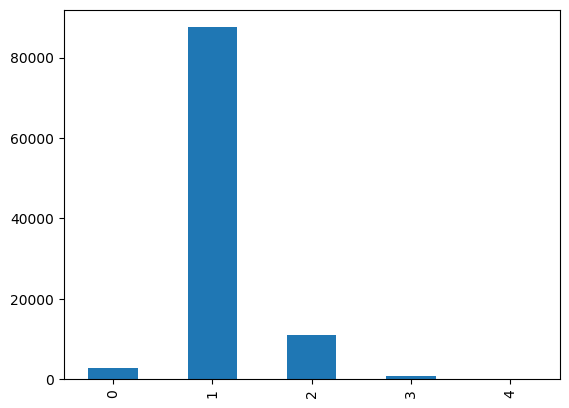

In [11]:
test = data.answers.apply(lambda x: len(x))
test.value_counts().sort_index().plot(kind='bar')
plt.show()

There are answers that are composed of multiple text but to simplify and gain some time we'll only use the first text as an answer.
For these without text (0 text) we will delete the rows

df["answers"] = df["answers"].apply(lambda x: x[0] if len(x)==0 else '')

df = df[df["answers"]!=''].reset_index(drop=True)

## Passages

In [12]:
data['passages'][0]

{'is_selected': [1, 0, 0, 0, 0, 0],
 'passage_text': ['The average Walgreens salary ranges from approximately $15,000 per year for Customer Service Associate / Cashier to $179,900 per year for District Manager. Average Walgreens hourly pay ranges from approximately $7.35 per hour for Laboratory Technician to $68.90 per hour for Pharmacy Manager. Salary information comes from 7,810 data points collected directly from employees, users, and jobs on Indeed.',
  'The average revenue in 2011 of a Starbuck Store was $1,078,000, up  from $1,011,000 in 2010.    The average ticket (total purchase) at domestic Starbuck stores in  No … vember 2007 was reported at $6.36.    In 2008, the average ticket was flat (0.0% change).',
  'In fiscal 2014, Walgreens opened a total of 184 new locations and acquired 84 locations, for a net decrease of 273 after relocations and closings. How big are your stores? The average size for a typical Walgreens is about 14,500 square feet and the sales floor averages abo


Let's see now is each answer has a context by seeing if there is a text selected (in is_selected) but without including the ones concerned about the previous test

In [13]:
from more_itertools import locate
test = data.passages.apply(lambda x: list(locate(x["is_selected"], lambda y: y == 1)) if sum(x["is_selected"])>0 else '')
test = test[test=='']
len(test)

3268

We have rows without passage text selected so we'll delete these elements

df['is_selected'] = df['is_selected'].apply(lambda x: x.index(1) if 1 in x else '')

df = df[df['is_selected']!=''].reset_index(drop=True)


df['answers'] = df.apply(lambda x: x['answers'] if x['answers'] in x["passage_text"][x["is_selected"]] else '')

df = df[df['answers']!='']

## Query

In [14]:
data['query']

0                     walgreens store sales average
1                       how much do bartenders make
2                           what is a furuncle boil
3                        what can urinalysis detect
4                        what is vitamin a used for
                            ...                    
102018    how long can you keep bacon in the fridge
102019     what is growth bmi mean in medical terms
102020       can an llc apply for more than one dba
102021                      bisque color definition
102022                     what are synthetic drugs
Name: query, Length: 102023, dtype: object

We check that if there are any rows missing a query

In [15]:
test = data[data['query']=='']
len(test)

0

No missing query so we don't have to do anything on this column

## Query_id

Here we just have to check that every rows has:
- a valid query_id

In [16]:
test = data['query_id'].apply(lambda x: isinstance(x, (int, np.integer)))
len(test[test==False])

0

- its query_id is unique

In [17]:
len(data.query_id.unique()) == len(data)

True

With these results we can say that there is also no changes to do on that column

## Query_type

In [18]:
data["query_type"].head(5)

0        numeric
1        numeric
2    description
3    description
4    description
Name: query_type, dtype: object

Let's first see what are the different types

In [19]:
data["query_type"].unique()

array(['numeric', 'description', 'location', 'entity', 'person'],
      dtype=object)

The labels seems okay so there is again nothing to do on that columns.
Let's see the repartition, just out of curiosity:

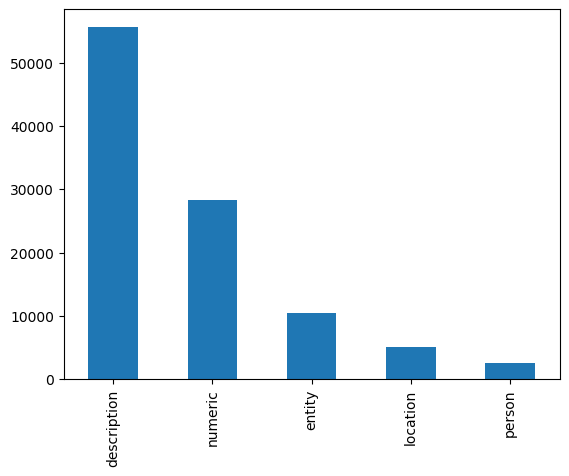

In [20]:
data["query_type"].value_counts().plot(kind='bar')
plt.show()

## wellFormedAnswers

In [21]:
data["wellFormedAnswers"].head(5)

0    []
1    []
2    []
3    []
4    []
Name: wellFormedAnswers, dtype: object

Let's see what type of value this column can have because after some observation it seems only composed of empty lists

In [22]:
data["wellFormedAnswers"].apply(lambda x: ''.join(x)).unique()

array([''], dtype=object)

It is the case so the column is not really useful and we will drop it

df = df.drop('wellFormedAnswers', axis=1)

---
# Feature Engineering 

Here, we'll apply the cleaning we talked about in the previous part but also all the transformations needed to have the ideal format to then be used by the model. 

## Ideal Format

To run the model, the ideal format would be to transform the dataset into a format a bit similar to SQUAD dataset to be ae to be tokenized and then processed in the training:
- query_id (int32) : same as previously
- context (string) : here is in fact the combination of all the passage text
- query (string) : same as previously
- answers (dictionary):
  - text (string) : answer
  - answer_start (int32) : the index of the first character of the answer inside the context
  - answer_end (int32) : the index of the last character of the answer inside the context

## Transformation and Cleaning

Let's now apply all what we talked about.

NB: for easy manipulation we split passage column dict into 3 column

In [108]:
df = pd.concat([data.drop(['passages'], axis=1),
                data['passages'].apply(pd.Series)], axis=1)
df.head(3)

,answers,query,query_id,query_type,wellFormedAnswers,is_selected,passage_text,url
0,"[Approximately $15,000 per year.]",walgreens store sales average,9652,numeric,[],"[1, 0, 0, 0, 0, 0]",[The average Walgreens salary ranges from appr...,"[http://www.indeed.com/cmp/Walgreens/salaries,..."
1,"[$21,550 per year, The average hourly wage for...",how much do bartenders make,9653,numeric,[],"[0, 1, 0, 0, 0, 0, 0, 0]",[A bartender’s income is comprised mostly of t...,[http://www.breakintobartending.com/how-much-d...
2,"[A boil, also called a furuncle, is a deep fol...",what is a furuncle boil,9654,description,[],"[0, 0, 0, 0, 0, 0, 1, 0]","[Knowledge center. A boil, also known as a fur...",[http://www.medicalnewstoday.com/articles/1854...


In [109]:
# Change format of is_selected to something usable
df['is_selected'] = df['is_selected'].apply(lambda x: x.index(1) if 1 in x else '')
df = df[df['is_selected']!=''].reset_index(drop=True)

# Keep only rows with answers composed of at least 1 text but select inly the first if more than 1
df["answers"] = df["answers"].apply(lambda x: x[0] if len(x)>0 else '')
df = df[df["answers"]!=''].reset_index(drop=True)

# Drop answers that are not a direct extract of the selected passage_text
df['answers'] = df.apply(lambda x: x['answers'] if (x['answers'] in x["passage_text"][x["is_selected"]]) else '', axis=1)
df = df[df['answers']!=''].reset_index(drop=True)

# Replace answers by the right format (transform to dict + add answer start and end indexes of inside de context)
df['answers'] = df.apply(lambda x: {"text": x['answers'],
                                    "answer_start":[x['passage_text'][x['is_selected']].find(x['answers'])],
                                    "answer_end": [x['passage_text'][x['is_selected']].find(x['answers'])
                                                   + len(x['answers'])]}
                                    if x['is_selected']==0
                                    else {"text": x["answers"],
                                          "answer_start":[sum([len(x["passage_text"][i]) for i in range(x["is_selected"])])
                                                          + int(x['passage_text'][x['is_selected']].find(x['answers']))
                                                          + x['is_selected']],
                                          "answer_end": [sum([len(x["passage_text"][i]) for i in range(x["is_selected"])])
                                                          + x['passage_text'][x['is_selected']].find(x['answers'])
                                                          + x['is_selected']
                                                          + len(x['answers'])]},
                        axis=1)

# Transform passage text to string and rename it as context
df['passage_text'] = df['passage_text'].apply(lambda x: ' '.join(x))
df = df[df['passage_text']!=''].reset_index(drop=True)
df = df.rename(columns={"passage_text": "context"})

# Delete all useless columns
df = df.drop(['wellFormedAnswers','query_type','is_selected','url'], axis=1)

In [110]:
df.head(5)

,answers,query,query_id,context
0,{'text': 'The initiation of cell transformatio...,what causes genetic alterations in normal cells,9657,1 Fail to stop uncontrolled cell growth. 2 No...
1,"{'text': '$2.51 - $3.17 per square foot', 'ans...",cost to frame basement,9658,1 A lot depends on how much is included and th...
2,"{'text': 'Bodega Lane, Bodega, Northern Califo...",where was movie the birds filmed,9661,The greatest films The Greatest and the Best i...
3,"{'text': '$306', 'answer_start': [2553], 'answ...",cost to file bankruptcy in virginia,9662,People in Northern Virginia were hit hard by t...
4,{'text': 'The hummingbird moth is an enchantin...,what is a hummingbird moth,9663,Hummingbird Moth. The hummingbird moth is an e...


In [113]:
df.answers[0]

{'text': 'The initiation of cell transformation is generally associated with genetic alterations in normal cells that lead to the loss of intercellular-and/or extracellular-matrix- (ECM-) mediated cell adhesion.',
 'answer_start': [2560],
 'answer_end': [2761]}

We just check that the mapping is correct by:
- first check that the length of the answer is always correct

In [114]:
test = df.answers.apply(lambda x: len(x['text'])==(x['answer_end'][0]-x['answer_start'][0]))
test[test==False]

Series([], Name: answers, dtype: bool)

- then by checking that the text and indexes we took are the right ones

In [115]:
test = df.apply(lambda x: x['answers']['text'] == x['context'][x['answers']['answer_start'][0]:x['answers']['answer_end'][0]], axis=1)
test[test==False]

Series([], dtype: bool)

Everything is okay so now we can store the modified dataset in S3 that we'll be then process by SKLearn processing so that we'll have all permission to do the training after doing the SKLearn job

In [116]:
file_name = 'MS_Marco.csv'
df = df.sample(frac=1, random_state=42).reset_index(drop=True)   # Randomly sort the data then split out first 70%, second 20%, and last 10%
df.to_csv(file_name,index=False)

s3.meta.client.upload_file(file_name, bucket, f'{prefix}/input_data/MS_Marco.csv')

sess = Session()
input_source = sess.upload_data(file_name, bucket=bucket, key_prefix=f'{prefix}/input_data')
input_source

's3://sagemaker-us-east-1-376887058029/final_project/input_data/MS_Marco.csv'